Notebooks con el tema de Marginación

23b-Group-block-hex
23c-Group-block-hex
29-Population-correlation

## Importing libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import esda
import pysal
import libpysal as lps
from splot import esda as esdaplot


module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-02-28 21:56:18 Configured OSMnx 1.1.1
2023-02-28 21:56:18 HTTP response caching is on


## Downloading data

Pop data

In [8]:
pop_hex9 = aup.gdf_from_db('censo_10_20_hexres8','censo')
pop_hex9.city.unique()

array(['ZMVM', 'Guadalajara', 'Monterrey'], dtype=object)

Marginalization data

In [10]:
gdf_tmp = pop_hex9.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [11]:
query = f"SELECT * FROM censo.hex_bins_marg_2020 WHERE (ST_Intersects(geometry, \'SRID=4326; {poly_wkt}\'))"
marg_hex9 = aup.gdf_from_query(query, geometry_col='geometry')
print(marg_hex9.shape)
marg_hex9.head(2)

(6406, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-99.17740 19.48241, -99.17776 19.487...",884995b8c1fffff,09002,14474.150,11.159615,39.639160,60.006165,0.094840,0.109755,0.752394,0.921807,8.358856,45.407722,16.135150,54.746320,123.545098,0.965088
1,"POLYGON ((-99.17884 19.50300, -99.17848 19.497...",884995b88dfffff,09002,5324.688,12.022201,22.668638,27.020708,0.101111,0.016225,5.099980,1.091457,5.453633,28.146427,7.906191,28.952435,123.916076,0.967986


## Merging geodataframes

In [22]:
fields_to_keep = ['hex_id_8','pobtot','tothog','hogjef_f','10_pobtot','10_tothog','10_hogjef_f','geometry','city']
pop_hex9_f = pop_hex9[fields_to_keep]
pop_hex9_f.head(1)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry,city
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM


In [23]:
fields_to_keep = ['hex_id_8','im_2020','imn_2020','geometry']
marg_hex9_f = marg_hex9[fields_to_keep]
marg_hex9_f.head(1)

,hex_id_8,im_2020,imn_2020,geometry
0,884995b8c1fffff,123.545098,0.965088,"POLYGON ((-99.17740 19.48241, -99.17776 19.487..."


In [25]:
pop_marg_hex9 = pop_hex9_f.merge(marg_hex9_f, on='hex_id_8')
pop_marg_hex9.head(1)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM,118.096535,0.922526,"POLYGON ((-98.95114 19.76845, -98.95603 19.770..."


## Data analysis

Calculating change in %hogjef from 2010 to 2020

In [27]:
pop_marg_hex9['%hogjef_f'] = (pop_marg_hex9['hogjef_f'] / pop_marg_hex9['tothog'])*100
pop_marg_hex9['%10_hogjef_f'] = (pop_marg_hex9['10_hogjef_f'] / pop_marg_hex9['10_tothog'])*100
pop_marg_hex9['chg_%hogjef_f'] = pop_marg_hex9['%hogjef_f'] - pop_marg_hex9['%10_hogjef_f']
pop_marg_hex9.head(2)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y,%hogjef_f,%10_hogjef_f,chg_%hogjef_f
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM,118.096535,0.922526,"POLYGON ((-98.95114 19.76845, -98.95603 19.770...",26.169591,13.893967,12.275624
1,8849958da5fffff,10322.0,2682.0,763.0,7725.0,1837.0,361.0,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",ZMVM,118.539489,0.925986,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",28.448919,19.651606,8.797313


Calculating marginalization categories

In [29]:
pop_marg_hex9['grado_marg'] = np.nan
pop_marg_hex9.loc[pop_marg_hex9.imn_2020>=0.966338 , 'grado_marg'] = 'Muy bajo'
pop_marg_hex9.loc[(pop_marg_hex9.imn_2020>=0.946436 ) & (pop_marg_hex9.imn_2020<0.966338), 'grado_marg'] = 'Bajo'
pop_marg_hex9.loc[(pop_marg_hex9.imn_2020>=0.926536) & (pop_marg_hex9.imn_2020<0.946436), 'grado_marg'] = 'Medio'
pop_marg_hex9.loc[(pop_marg_hex9.imn_2020>=0.8999) & (pop_marg_hex9.imn_2020<0.926536), 'grado_marg'] = 'Alto'
pop_marg_hex9.loc[pop_marg_hex9.imn_2020 < 0.8999, 'grado_marg'] = 'Muy alto'
pop_marg_hex9.head(2)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y,%hogjef_f,%10_hogjef_f,chg_%hogjef_f,Grado_Marg,grado_marg
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM,118.096535,0.922526,"POLYGON ((-98.95114 19.76845, -98.95603 19.770...",26.169591,13.893967,12.275624,Alto,Alto
1,8849958da5fffff,10322.0,2682.0,763.0,7725.0,1837.0,361.0,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",ZMVM,118.539489,0.925986,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",28.448919,19.651606,8.797313,Alto,Alto


Calculating average change in %hogjef_f by grado_marg

In [50]:
#Finding None values in 'chg_%hogjef_f' and changing them to 0
#First we create a boolean mask where there is nan in 'name'
idx = pop_marg_hex9['chg_%hogjef_f'].isna()
#Then, in that boolean mask, we change 'chg_%hogjef_f' to 0
#pop_marg_hex9.loc[idx, 'chg_%hogjef_f'] = 0

nodata = pop_marg_hex9.loc[idx]
print(nodata)
print(nodata['10_pobtot'].sum())

             hex_id_8  pobtot  tothog  hogjef_f  10_pobtot  10_tothog  \
6     8849953037fffff   931.0   277.0      94.0        0.0        0.0   
17    884995a009fffff  1737.0   576.0     130.0        0.0        0.0   
23    8849950637fffff     0.0     0.0       0.0        0.0        0.0   
41    8849958b1bfffff     0.0     0.0       0.0        0.0        0.0   
63    8849953065fffff     0.0     0.0       0.0        0.0        0.0   
...               ...     ...     ...       ...        ...        ...   
6152  8848a201b5fffff    12.0     0.0       0.0        4.0        0.0   
6158  8848a20a41fffff  1740.0   616.0     200.0        0.0        0.0   
6161  8848a20ab5fffff  6365.0  1810.0     545.0        0.0        0.0   
6166  8848a20c93fffff   489.0   161.0      45.0        0.0        0.0   
6194  8848a20257fffff   220.0    44.0       0.0        0.0        0.0   

      10_hogjef_f                                         geometry_x  \
6             0.0  POLYGON ((-99.09155 19.81245, -9

In [67]:
hogjef_f_bymarg = pop_marg_hex9.groupby('grado_marg').agg({'chg_%hogjef_f':np.nanmean})
hogjef_f_bymarg = hogjef_f_bymarg.reset_index()
hogjef_f_bymarg

,grado_marg,chg_%hogjef_f
0,Alto,10.757931
1,Bajo,10.198740
2,Medio,10.783619
3,Muy alto,12.742203
4,Muy bajo,9.310988


Text(0, 0.5, 'Cambio en el porcentaje de hogares con jefatura femenina (2010 vs 2020)')

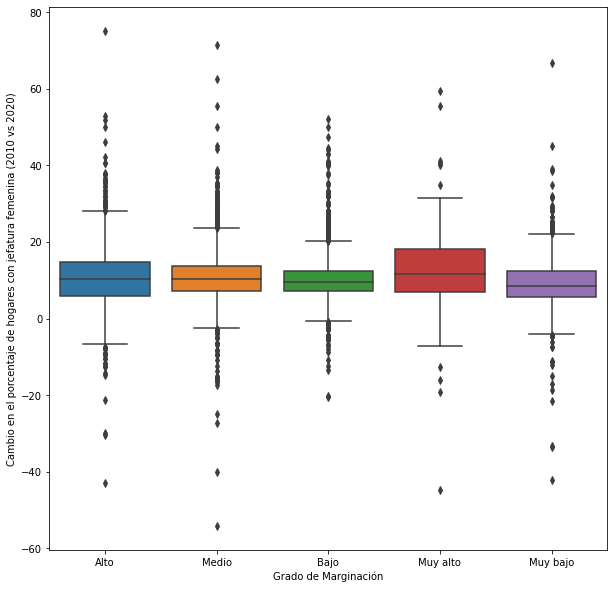

In [74]:
fig, ax = plt.subplots(figsize=(10,10))

x = np.array(pop_marg_hex9.grado_marg)
y = np.array(pop_marg_hex9['chg_%hogjef_f'])

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Grado de Marginación')
plt.ylabel('Cambio en el porcentaje de hogares con jefatura femenina (2010 vs 2020)')